# Skew-symmetric operator

A simple example of monotone operator that is not (even locally) strongly monotone is the skewed-symmetric operator [1], $F : \mathbb{R}^{MN} \to \mathbb{R}^{MN}$, which is described as follows

$$
\begin{equation}
    F(\mathbf{x}) = \begin{bmatrix} \mathbf{A}_1 & & \\ & \ddots & \\ & & \mathbf{A}_M \end{bmatrix} \mathbf{x}
\end{equation}
$$

for a given $M \in \mathbb{N}$, where $\mathbf{A}_i = \text{tril}(\mathbf{B}_i) - \text{triu}(\mathbf{B}_i)$, for some arbitrary $0 \preceq \mathbf{B}_i \in \mathbb{R}^{N \times N}$, for all $i = 1, \dots, M$. Let's implement it by first creating the problem data

In [1]:
import numpy as np
import scipy as sp
import cvxpy as cp
import matplotlib.pyplot as plt

from monviso import VI

np.random.rand(2024)

M, N = 20, 10
make_positive_semidefinite = lambda X: X * X.T

Bs = [make_positive_semidefinite(np.random.rand(N, N)) for _ in range(M)]
A = sp.linalg.block_diag(*[np.tril(B) - np.triu(B) for B in Bs])

Then, let's define $\mathbf{F}(\cdot)$ with it's Lipschitz constant $L$

In [2]:
F = lambda x: A @ x
L = np.linalg.norm(A, 2)

Finally, let's create the VI problem and an initial solution

In [3]:
sso = VI(F)
x = np.random.rand(N * M)

The vector map $\mathbf{F}(\cdot)$ is merely monotone; we can use and compare three different algorithms: fast optimistic gradient descent-ascent ([`fogda`](../../api/#explicit-fast-optimistic-gradient-descent-ascent)), golden ratio ([`graal`](../../api/#golden-ratio-algorithm)), adaptive golden ratio ([`agraal`](../../api/#adaptive-golden-ratio-algorithm))

In [5]:
GOLDEN_RATIO = 0.5 * (1 + np.sqrt(5))

max_iter = 200

residuals_fogda = np.zeros(max_iter)
residuals_graal = np.zeros(max_iter)
residuals_agraal = np.zeros(max_iter)

# Copy the same initial solution for the three methods
xk_fogda, x1k_fogda, y1k_fogda = np.copy(x), np.copy(x), np.copy(x)
xk_graal, yk_graal = np.copy(x), np.copy(x)
xk_agraal, x1k_agraal, yk_agraal, s1k_agraal, tk_agraal = \
    np.copy(x), np.random.rand(N * M), np.copy(x), GOLDEN_RATIO/(2*L), 1

for k in range(max_iter):
    # Fast Optimistic Gradient Descent Ascent 
    xk1_fogda, yk_fogda = sso.fogda(xk_fogda, x1k_fogda, y1k_fogda, k, step_size=1/(4*L))
    residuals_fogda[k] = np.linalg.norm(xk1_fogda - xk_fogda)
    xk_fogda, x1k_fogda, y1k_fogda = xk1_fogda, xk_fogda, yk_fogda

    # Golden ratio algorithm
    xk1_graal, yk1_graal = sso.graal(xk_graal, yk_graal, step_size=GOLDEN_RATIO/(2*L))
    residuals_graal[k] = np.linalg.norm(xk1_graal - xk_graal)
    xk_graal, yk_graal = xk1_graal, yk1_graal

    # Adaptive golden ratio algorithm
    xk1_agraal, yk1_agraal, sk_agraal, tk1_agraal = sso.agraal(xk_agraal, x1k_agraal, yk_agraal, s1k_agraal, tk_agraal)
    residuals_agraal[k] = np.linalg.norm(xk1_agraal - xk_agraal)
    xk_agraal, x1k_agraal, yk_agraal, s1k_agraal, tk_agraal = xk1_agraal, xk_agraal, yk1_agraal, sk_agraal, tk1_agraal

The API docs have some detail on the [convention for naming iterative steps](../../api/#iterative-methods). Let's check out the residuals for each method. 

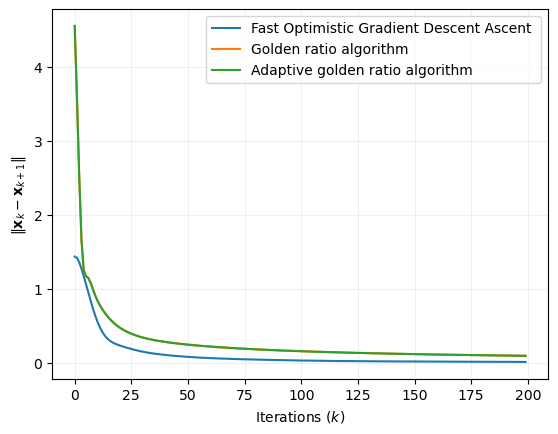

In [6]:
fig, ax = plt.subplots()

ax.plot(residuals_fogda, label="Fast Optimistic Gradient Descent Ascent ")
ax.plot(residuals_graal, label="Golden ratio algorithm")
ax.plot(residuals_agraal, label="Adaptive golden ratio algorithm")

ax.grid(True, alpha=0.2)
ax.set_xlabel("Iterations ($k$)")
ax.set_ylabel(r"$\|\mathbf{x}_k - \mathbf{x}_{k+1}\|$")
plt.legend()
plt.show()

## References
[1] Bauschke, H. H., & Combettes, P. L. Convex Analysis and Monotone Operator Theory in Hilbert Spaces.